In [1]:
import cv2 #version 3.3.1
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
import glob
import os
import imutils
import math

In [2]:
def plot(img, title, size, gray):
    plt.figure(figsize=size)
    if gray=='gray':
         plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()
    
def size_lookup(wert):
    real_diam = 0;
    
    if wert == 1:
        real_diam = 16.25
    elif wert == 2:
        real_diam = 18.75
    elif wert == 5:
        real_diam = 21.25
    elif wert == 10:
        real_diam = 19.75
    elif wert == 20:
        real_diam = 22.25
    elif wert == 50:
        real_diam = 24.25
    elif wert == 100:
        real_diam = 23.25
    elif wert == 200:
        real_diam = 25.75
            
    return real_diam

def value_lookup(size):
    real_diam = 0;
    
    if size == 16.25:
        real_diam = 1
    elif size == 18.75:
        real_diam = 2
    elif size == 21.25:
        real_diam = 5
    elif size == 19.75:
        real_diam = 10
    elif size == 22.25:
        real_diam = 20
    elif size == 24.25:
        real_diam = 50
    elif size == 23.25:
        real_diam = 100
    elif size == 25.75:
        real_diam = 200
            
    return real_diam

def gray(img):
    # Graustufenumwandlung
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

def contrast_enhancement(img):
    # Anwenden der Kontrastverstärkung
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img)
    return img_enhanced

def gauss_blurr(img):
    img_blurred = cv2.GaussianBlur(img, (7, 7), 0)
    return img_blurred

# not self written
def match(image, template):
    # Store width and heigth of template in w and h
    (tH, tW) = template.shape[:2]
    found = None
 
    for scale in np.linspace(0.2, 1.0, 20)[::-1]:
        # resize the image according to the scale, and keep track
        # of the ratio of the resizing
        resized = imutils.resize(template, width = int(template.shape[1] * scale))
        r = template.shape[1] / float(resized.shape[1])
 
        # if the resized image is smaller than the template, then break
        # from the loop
        if resized.shape[0] < tH or resized.shape[1] < tW:
            break
            
        result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF)
        (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

 
        # if we have found a new maximum correlation value, then ipdate
        # the bookkeeping variable
        if found is None or maxVal > found[0]:
            found = (maxVal, maxLoc, r)
  
    # unpack the found varaible and compute the (x, y) coordinates
    # of the bounding box based on the resized ratio
    (_, maxLoc, r) = found
    (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
    (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))

    # draw a bounding box around the detected result and display the image
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    
    return image

def get_values(diam, mat):
    values = []
    
    i = 0
    total = 0
    for d in diam:
        t = "Unknown"

        # compare to known diameters with some margin for error
        if mat[i] == "gold/silber": #and math.isclose(d, 25.75, abs_tol=1.25) 
            t = "2 Euro"
            total += 200
        elif mat[i] == "silber/gold": #and math.isclose(d, 23.25, abs_tol=2.5)
            t = "1 Euro"
            total += 100
        elif mat[i] == "gold":
            if math.isclose(d, 24.25, abs_tol=2.0):
                t = "50 Cent"
                total += 50
            elif math.isclose(d, 22.25, abs_tol=2.0):
                t = "20 Cent"
                total += 20
            elif math.isclose(d, 19.75, abs_tol=1.25):
                t = "10 Cent"
                total += 10
            
        elif mat[i] == "kupfer":
            if math.isclose(d, 21.25, abs_tol=2.5):
                t = "5 Cent"
                total += 5
            elif math.isclose(d, 18.75, abs_tol=1.25):
                t = "2 Cent"
                total += 2
            elif math.isclose(d, 16.25, abs_tol=1.25):
                t = "1 Cent"
                total += 1
        
        values.append(t)
        
        i += 1
        
    return(values, total)

def classify_coin(coin):
    # randerkennung
    height, width, _ = coin.shape
    
    # randauschnitt und ausschnitt aus Mitte
    rand = coin[5:15, 5:15]
    mitte = coin[int(height/2)-10:int(height/2)+10, int(width/2)-10:int(width/2)+10]
    
    # farben berechnen
    rand_color = rand.mean(axis=(0, 1))
    mitte_color = mitte.mean(axis=(0,1))
    
    #plot(coin, "münze", (2,2), _)
    #plot(rand, "münze", (2,2), _)
    #plot(mitte, "münze", (2,2), _)
    
    # materialerkennung
    mat = -1
    mat_rand = -1
    
    a_rand = rand_color[1]-rand_color[0] 
    b_rand = mitte_color[1]-mitte_color[2]
    x_rand = abs(a_rand) - abs(b_rand)
    if x_rand > 10:
        mat_rand = 1 
    else:
        mat_rand = 0 
    
    a_mitte = mitte_color[1]-mitte_color[0] 
    b_mitte = mitte_color[1]-mitte_color[2]
    x_mitte = abs(a_mitte) - abs(b_mitte)
    if x_mitte > 10:
        mat = 1
    else:
        mat = 0
     
    # bei Farbabweichung -> mixmaterial
    if mat != mat_rand:
        #Prüfe verhältniss von Rand zur Mitte
#        if abs(mitte_color[1] - rand_color[1]) >= 20 and abs(mitte_color[2] - rand_color[2]) >= 20:
        if rand_color[0] > 120:
            return "gold/silber" #2 Euro
        elif rand_color[0] <= 120:
            return('silber/gold') #1 Euro
    elif mat == 1:
        return('gold')
    else: 
        return('kupfer')
    

In [3]:
filename = "50_1.JPG"
smallest_coin_value = 50

# datei einlesen
image = cv2.imread(filename)
if image is None:
    print("Unable to open " + filename)
    exit(-1)
    
# load all sample images
#samples = []
#for img in glob.glob("./samples/*.jpg"):
#    sample= cv2.imread(img)
#    base = os.path.basename(img)
#    name = os.path.splitext(base)[0]
#    sample = gray(sample)
#    samples.append((name, sample))
        
        
# resize 
d = 1024 / image.shape[1]
dim = (1024, int(image.shape[0] * d))
image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    
image_cpy = image.copy()

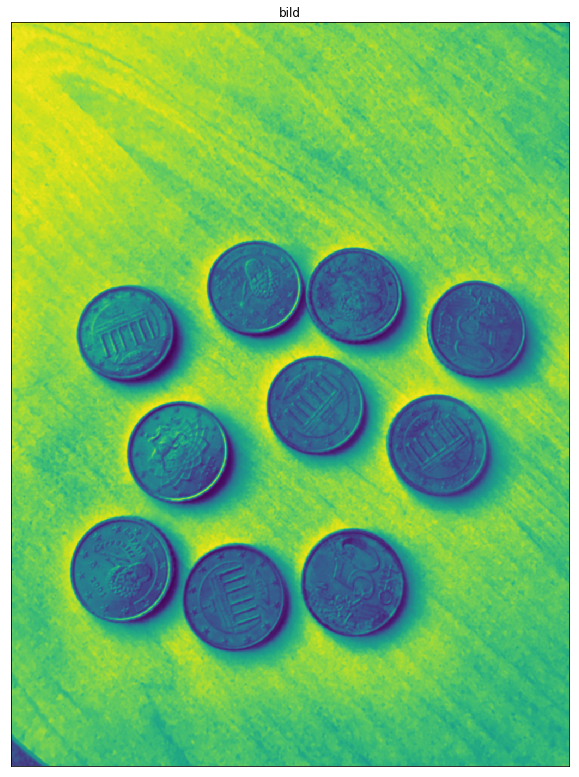

81
84
85
85
87
88
90
[81, 84, 85, 85, 87, 88, 90, 92, 97, 99]
85.71428571428571
85.71428571428571


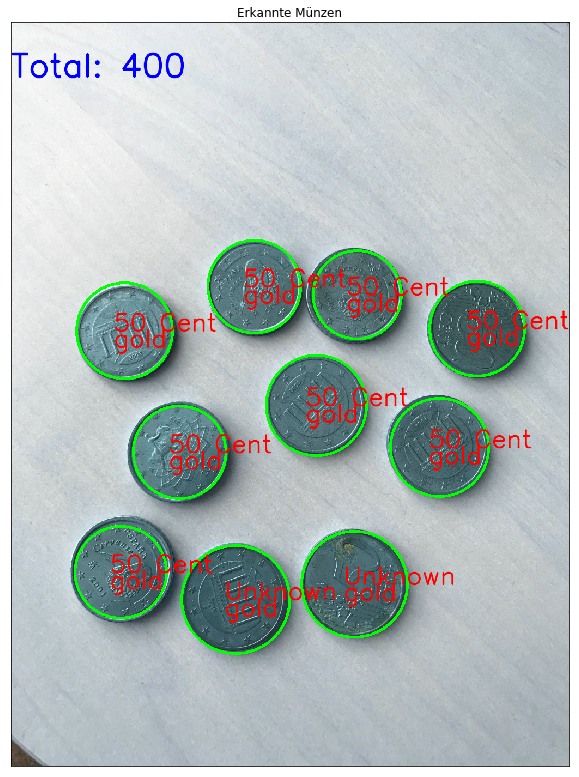

In [4]:
img_temp = image
image_gray = gray(image)
image_gray = contrast_enhancement(image_gray)
blurred = gauss_blurr(image_gray)

plot(blurred, "bild", (10,20), gray)

circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=2.2, minDist=100, param1=200, param2=100, minRadius=60, maxRadius=120)

diam = []
mat = []

if circles is not None:
# runden der Zahlen
    circles = np.round(circles[0, :]).astype("int")
     
    # durch alle erkannten Kreise durchiterieren
    for (x, y, rad) in circles:
        # Kreis zeichnen
        cv2.circle(image_cpy, (x, y), rad, (0, 255, 0), 4)
        # Radius einzeichnen
        #cv2.putText(image_cpy, str(rad), (x-20,y), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), thickness=2, lineType=cv2.LINE_AA)
        diam.append(rad)
        # Münze ausschneiden und klassifizieren
        res = classify_coin(image[y - rad+20:y + rad-20, x - rad+20:x + rad-20])
        if res == "gold/silber":
            img_temp = image[y - rad+20:y + rad-20, x - rad+20:x + rad-20]
        mat.append(res)
        cv2.putText(image_cpy, res, (x-20,y+30), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), thickness=2, lineType=cv2.LINE_AA)

        
    smallest = min(diam)

    #TODO: Mittelwert der kleinsten münzen +-1mm?
    i = 0
    size = 0
    for val in sorted(diam):
        if(val <= smallest + 10):
            print(val)
            size = size + val
            i = i+1
    
    size = size/i
    smallest = size
    print(sorted(diam))
    print(size)
    print(smallest)
    
    
    
    # größe der kleinsten Münze herausfinden
    size = size_lookup(smallest_coin_value)

    diam = [x / smallest * size for x in diam]

    val = get_values(diam, mat)

    i = 0
    for (x, y, rad) in circles:
        cv2.putText(image_cpy, val[0][i], (x-20,y), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), thickness=2, lineType=cv2.LINE_AA)
        i += 1

    cv2.putText(image_cpy, "Total: "+ str(val[1]), (0,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), thickness=3, lineType=cv2.LINE_AA)
        
plot(image_cpy, 'Erkannte Münzen', (10,20), _)